In [1]:
# Importing modules
import torch as to
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch.utils.data as to_data
from torch.utils.tensorboard import SummaryWriter as sumwriter
import os as os

In [2]:
# Specify hardware for ML training (GPU default)
device = "cuda" if to.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Quickly generate list of strings for frequency numbers and ratios
def freq_name(no_freq, include_freq=True, include_ratio=True):
    """
    Creates an ordered list of string from inputted parameters:

    no_freq = (int) number of desired frequencies
    include_freq = (bool) include the individual frequencies or not (default True)
    include_ratio = (bool) include the non-trivial ratios between frequencies or not (default True)
    """
    names = []
    if include_freq:
        for i in range(no_freq):
            names.append('f'+str(i+1))
    if include_ratio:
        for i in range(no_freq):
            for j in range(i):
                names.append('f'+str(i+1)+'/f'+str(j+1))
    return names

In [4]:
def activation(activ_name):
    if activ_name=='relu':
        return to.nn.ReLU()
    elif activ_name=='lrelu':
        return to.nn.LeakyReLU()
    elif activ_name=='prelu':
        return to.nn.PReLU()
    elif activ_name=='relu6':
        return to.nn.ReLU6()
    elif activ_name=='sigmoid':
        return to.nn.Sigmoid()
    elif activ_name=='tanh':
        return to.nn.Tanh()
    elif activ_name=='silu':
        return to.nn.SiLU()
    elif activ_name=='selu':
        return to.nn.SELU()
    elif activ_name=='celu':
        return to.nn.CELU()
    elif activ_name=='gelu':
        return to.nn.GELU()
    else:
        return to.nn.ReLU()

In [5]:
class SAE_data(to_data.Dataset):
    def __init__(self, scaled_dataframe, X_names, Y_names):
        self.len = len(scaled_dataframe)
        self.X = to.from_numpy(scaled_dataframe[X_names].to_numpy().astype('float32')).to(device)
        self.Y = to.from_numpy(scaled_dataframe[Y_names].to_numpy().astype('float32')).to(device)

    def __len__(self):
        return self.len
  
    def __getitem__(self, idx):
        X_idx = self.X[idx,:]
        Y_idx = self.Y[idx,:]
        return X_idx, Y_idx

In [6]:
class SAE_Network(to.nn.Module):
    def __init__(self, num_X, num_Y, num_Z, he_nodes, hd_nodes, hactiv_type):
        super(SAE_Network, self).__init__()

        self.esec = []
        self.esec.append(to.nn.Linear(num_X+num_Y, he_nodes[0]))
        self.esec.append(activation(hactiv_type))

        for i in range(len(he_nodes)-1):
            self.esec.append(to.nn.Linear(he_nodes[i], he_nodes[i+1]))
            self.esec.append(activation(hactiv_type))

        self.esec.append(to.nn.Linear(he_nodes[-1], 2*num_Z))

        self.esec = to.nn.Sequential(*self.esec).to(device)
        for i in self.esec[::2]:
            to.nn.init.kaiming_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

        self.mu_layer = to.nn.Linear(2*num_Z, num_Z).to(device)
        to.nn.init.kaiming_uniform_(self.mu_layer.weight)
        to.nn.init.zeros_(self.mu_layer.bias)

        self.var_layer = to.nn.Linear(2*num_Z, num_Z).to(device)
        to.nn.init.kaiming_uniform_(self.var_layer.weight)
        to.nn.init.zeros_(self.var_layer.bias)


        self.dsec = []
        self.dsec.append(to.nn.Linear(num_X+num_Z, hd_nodes[0]))
        self.dsec.append(activation(hactiv_type))

        for i in range(len(hd_nodes)-1):
            self.dsec.append(to.nn.Linear(hd_nodes[i], hd_nodes[i+1]))
            self.dsec.append(activation(hactiv_type))

        self.dsec.append(to.nn.Linear(hd_nodes[-1], num_Y))
        
        self.dsec = to.nn.Sequential(*self.dsec).to(device)
        for i in self.dsec[::2]:
            to.nn.init.kaiming_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

    def reparameterize(self, mu, logvar):
        std = to.exp(0.5*logvar)
        eps = to.randn_like(std)
        return mu + eps*std

    def encode(self, X, Y):
        inputs = to.cat([Y, X], 1)
        Zp = self.esec(inputs)
        Z_mu = self.mu_layer(Zp)
        Z_var = self.var_layer(Zp)
        return Z_mu, Z_var
    
    def decode(self, X, Z): # P(x|z, c)
        inputs = to.cat([Z, X], 1) # (bs, latent_size+class_size)
        Yp = self.dsec(inputs)
        return Yp

    def forward(self, X, Y):
        Z_mu, Z_logvar = self.encode(X, Y)
        Z = self.reparameterize(Z_mu, Z_logvar)
        Yp = self.decode(X, Z)
        return Yp, Z_mu, Z_logvar

In [7]:
def train_epoch(
    network, num_freq,
    train_dataloader,
    loss_function, optimizer,
    tb_writer, epoch_ind
    ):

    loss_list = []

    for i, data in enumerate(train_dataloader):
        X, Y = data

        # if epoch_ind==0 and i==0:
        #     tb_writer.add_graph(network, (Y,X), verbose=False)

        optimizer.zero_grad()
        Yp, Z_mu, Z_logvar = network(X, Y)

        loss = loss_function(Yp, Y) -0.5 * to.sum(1 + Z_logvar - Z_mu.pow(2) - Z_logvar.exp())
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()
    
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

def valid_epoch(
    network, num_freq,
    valid_dataloader,
    loss_function
    ):

    loss_list = []

    for i, data in enumerate(valid_dataloader):
        X, Y = data
        Yp, Z_mu, Z_logvar = network(X, Y)
        loss = loss_function(Yp, Y) -0.5 * to.sum(1 + Z_logvar - Z_mu.pow(2) - Z_logvar.exp())

        loss_list.append(loss.item())
        
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

In [8]:
def train_AEI(
    network, num_freq,
    train_dataloader, valid_dataloader,
    loss_function, optimizer_type,
    epochs, learn_rate
    ):

    if optimizer_type=='adam':
        optimizer = to.optim.Adam(network.parameters(), lr=learn_rate)
    else:
        optimizer = to.optim.SGD(network.parameters(), lr=learn_rate)
    
    tb_writer = sumwriter('Current_ML_Results/Tensorboard')
    
    for i in range(epochs):
        network.train(True)
        mloss = train_epoch(network, num_freq, train_dataloader, loss_function, optimizer, tb_writer, i)

        network.eval()
        with to.no_grad():
            vmloss = valid_epoch(network, num_freq, valid_dataloader, loss_function)
        

        print('-'*50)
        print('Epoch {} / {}'.format(i+1,epochs))
        print('-'*15)
        print('Average Train Loss : {}'.format(mloss))
        print('Average Validation Loss : {}'.format(vmloss))

        tb_writer.add_scalars("Batch Mean Loss",
                            {
                                'Train' : mloss,
                                'Validation' : vmloss
                            }, i+1)
                            
    tb_writer.flush()
    tb_writer.close()

In [9]:
# Prepare Data
import sklearn.preprocessing as sk_preproc
data = pd.read_csv('Data Workspace\FM_TV_Data.csv')
num_freq = 6

X_names = freq_name(num_freq,1,1)
Y_names = ['c', 'nu', 'a', 'b', 't']

train_split = int(0.8*len(data))
valid_split = len(data)- train_split

scaled_data = data[X_names+Y_names].copy()

# scaled_data['psi'] = np.log(scaled_data['psi'])
# scaled_data['E'] = scaled_data['E']/1e11
# scaled_data['rho'] = scaled_data['rho']/10000
# scaled_data['t'] = scaled_data['t']*100
scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])

scalerX = sk_preproc.StandardScaler()
scalerY = sk_preproc.StandardScaler()
scalerX.fit(scaled_data[X_names])
scalerY.fit(scaled_data[Y_names])

scaled_data[X_names]= scalerX.transform(scaled_data[X_names])
scaled_data[Y_names]= scalerY.transform(scaled_data[Y_names])

scaled_data = SAE_data(scaled_data, X_names, Y_names)
train_set, valid_set = to_data.random_split(scaled_data, [train_split, valid_split])

In [10]:
# Train Model
# Parameters
num_X = len(X_names)
num_Y = len(Y_names)
num_Z = 10
he_nodes = [60,55,50,45,40,35,30,25,20]
hd_nodes = [60,55,50,45,40,35,30,25,20][::-1]
hactiv = 'silu'

batch_size_train = 200
batch_size_valid = 2000

epochs = 100
learn_rate = 1e-3

# Optim Selections
loss_function = to.nn.SmoothL1Loss()
optimizer_type = 'adam'

# Data loaders
train_loader = to.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader = to.utils.data.DataLoader(valid_set, batch_size=batch_size_valid, shuffle=True)

# Model
model = SAE_Network(num_X, num_Y, num_Z, he_nodes, hd_nodes, hactiv)

In [11]:
# Train
train_AEI(
    model, num_freq,
    train_loader, valid_loader,
    loss_function, optimizer_type,
    epochs, learn_rate)

to.save(model.state_dict(), 'SAE_model.state')

--------------------------------------------------
Epoch 1 / 100
---------------
Average Train Loss : 16.293413162231445
Average Validation Loss : 8.602920532226562
--------------------------------------------------
Epoch 2 / 100
---------------
Average Train Loss : 0.8078553080558777
Average Validation Loss : 3.883915901184082
--------------------------------------------------
Epoch 3 / 100
---------------
Average Train Loss : 0.5203116536140442
Average Validation Loss : 2.370163917541504
--------------------------------------------------
Epoch 4 / 100
---------------
Average Train Loss : 0.40549397468566895
Average Validation Loss : 1.6446778774261475
--------------------------------------------------
Epoch 5 / 100
---------------
Average Train Loss : 0.33970922231674194
Average Validation Loss : 1.2370668649673462
--------------------------------------------------
Epoch 6 / 100
---------------
Average Train Loss : 0.30110207200050354
Average Validation Loss : 0.9787810444831848
----

In [12]:
# Prepare Data
data = pd.read_csv('Data Workspace\FM_Te_Data.csv')
scaled_data = data[X_names+Y_names].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])

scaled_data[X_names]= scalerX.transform(scaled_data[X_names])
scaled_data[Y_names]= scalerY.transform(scaled_data[Y_names])

scaled_data = SAE_data(scaled_data, X_names, Y_names)
test_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

with to.no_grad():
    for i, data in enumerate(test_loader):
        X, Y = data

        N = to.randn((X.shape[0], num_Z), device=device)
        predictY = model.decode(X, N)

        Y = to.from_numpy(scalerY.inverse_transform(Y.to('cpu'))).to(device)
        predictY = to.from_numpy(scalerY.inverse_transform(predictY.to('cpu'))).to(device)
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)

print(MAPE_per_dim)

tensor([17.0052,  3.4707, 14.4204, 14.6054, 19.6811], device='cuda:0',
       dtype=torch.float64)


In [15]:
abs_perc_error

tensor([[ 2.6331,  0.4060,  2.4802,  2.2927,  2.2828],
        [14.6085,  1.3770,  9.8466,  7.7057,  6.4808],
        [ 7.0710,  0.6241,  7.8435,  7.5034,  7.4043],
        ...,
        [10.0746,  0.9101, 21.8129, 20.6953, 54.7179],
        [24.4656,  0.2298, 12.5875, 11.3198,  7.6981],
        [ 1.9595, 18.0342,  6.6779,  7.9423, 10.9633]], device='cuda:0',
       dtype=torch.float64)

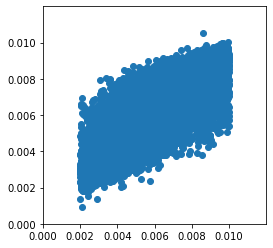

In [24]:
num = 4
plt.figure(figsize=(4,4))
plt.scatter(Y[:,num].to('cpu'), predictY[:,num].to('cpu'))
plt.xlim(0,max(1.2*max(Y[:,num].to('cpu')),1.2*max(Y[:,num].to('cpu'))))
plt.ylim(0,max(1.2*max(Y[:,num].to('cpu')),1.2*max(Y[:,num].to('cpu'))))
plt.show()